This step involves importing all the modules and packages that are essential for downscaling. It is equally important to import some modules from Bunge directory such as Utils, PAIRSSQL, AYP_Util, FileIO, PSQL, and feature selection.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
import geopandas as gpd
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import ipywidgets as widgets
from ipywidgets import Box

from datetime import datetime
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew

from statsmodels.tsa.filters.hp_filter import hpfilter
from bunge_utils import feature_selection as bfs

from bunge_utils import FileIO, PSQL, gcs

# Importing the packages

# User Input Settings

In [ ]:
harvest_year = 2024
#Length for crop growth stages
cs_dict = {'soybean': [0,50,70,120,140],
            'corn': [0,35,60,90,120,140]}
crop = 'soybean'
#The stages for soybean are veg, blooming, pod set/seed fill, & maturity.
#The stages for corn are early veg, veg growth, pollination/early milk, ...
# (contd.) milk/dough, dent, & maturity.

stage_list = cs_dict[f'{crop}']
stages = [1,2,3,4]
#Thresholds for GDD determination
upr_thr = [30.0,np.inf]
lwr_thr = [0,10.0]
#A general assumption that the soybean crop is planted on September 1 every year was made.
# This assumption was made only to determine the crop year. We have the actual planting dates for each year.
#  The actual planting dates would further be used for the determination of weather stages.
# The season length is 140 days.
crop_st_mmdd = 901
crop_st_date = '2022-09-01'

# Importing Datasets

## Correspondance table

In [ ]:
brz_adm2 = gcs.GS().open_gc_geojsonfile("gs://bunge-access-point/input/geojsons/BRZ_adm2.geojson")
map_code = brz_adm2[['vector_id','meso_iso']]
map_code['state'] = map_code.meso_iso.str.split('.', expand=True)[1]
map_code.rename(columns={'vector_id':'muni_iso'}, inplace=True)
map_code.shape

(5572, 3)

## Importing shapefiles

In [ ]:
shp_adm2 = gcs.GS().open_gc_geojsonfile("gs://bunge-access-point/input/geojsons/BRZ_adm2.geojson")
shp_adm1 = gcs.GS().open_gc_geojsonfile("gs://bunge-access-point/input/geojsons/BRZ_adm1.geojson")
shp_adm1_5 = gcs.GS().open_gc_geojsonfile("gs://bunge-access-point/input/geojsons/BRZ_adm1_5.geojson")

## Importing AOI Master

In [ ]:
# df_aoi_master = PSQL.get_aoi_master()
# df_aoi_master = df_aoi_master[(df_aoi_master['country'] == 'Brazil') &
#                               (df_aoi_master['vector_type'] == 'Municipalities')]
# df_aoi_master['vector_id'] = df_aoi_master['vector_id'].astype(int)
# df_aoi_master.head(2)

In [ ]:
# df_aoi_master.info()

## Loading adm2 weather data from PAIRS

### Cached Data method (Faster method)

This procedure takes around 90 seconds to download the weather datasets for Brazil.

In [ ]:
df_weather= PSQL.get_weather_data(
    _adm=2, _region='brazil', _model='unified', _sdt='19930101')

### Familiarization with data structure

ERA5 gives you a forecast for the next 10 days.

In [ ]:
display(df_weather.head())
display(df_weather.tail())
display(df_weather.info())

,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970
0,2022-01-01,59084,1,0101,30.1473,19.0307,0.231396,0.393128,0.349691,0.358248,2022,18993
1,2022-01-01,59085,1,0101,31.8902,20.5301,0.086573,0.343645,0.300278,0.331767,2022,18993
2,2022-01-01,59086,1,0101,31.5418,21.6468,0.627476,0.336284,0.288308,0.265224,2022,18993
3,2022-01-01,59087,1,0101,30.5700,19.4078,0.142491,0.386831,0.342914,0.370814,2022,18993
4,2022-01-01,59088,1,0101,32.1490,20.8563,0.081067,0.310112,0.265980,0.303083,2022,18993


,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970
62512742,2022-01-01,59079,1,0101,31.4594,19.6057,0.099176,0.370305,0.323682,0.348485,2022,18993
62512743,2022-01-01,59080,1,0101,31.5728,19.0324,0.018032,0.349245,0.307045,0.341744,2022,18993
62512744,2022-01-01,59081,1,0101,30.2751,19.6759,0.311607,0.364539,0.315226,0.359733,2022,18993
62512745,2022-01-01,59082,1,0101,30.6115,18.1661,0.015939,0.357755,0.302506,0.318800,2022,18993
62512746,2022-01-01,59083,1,0101,29.7749,19.0622,0.381850,0.371129,0.320293,0.354312,2022,18993


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62512747 entries, 0 to 62512746
Data columns (total 12 columns):
 #   Column    Dtype  
---  ------    -----  
 0   date      object 
 1   aoi_id    int64  
 2   doy       int64  
 3   mmdd      object 
 4   tmax      float64
 5   tmin      float64
 6   precip    float64
 7   swvl1     float64
 8   swvl2     float64
 9   swvl3     float64
 10  year      int64  
 11  days1970  int64  
dtypes: float64(6), int64(4), object(2)
memory usage: 5.6+ GB


None

In [ ]:
df_weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
aoi_id,62512747.0,56783.934017,1610.191296,38870.000000,55388.000000,56783.000000,58177.000000,59572.000000
doy,62512747.0,182.750278,105.249976,1.000000,92.000000,183.000000,274.000000,366.000000
tmax,62512747.0,27.719210,4.405848,1.901640,25.292000,28.302200,30.661000,42.123600
tmin,62512747.0,19.072756,4.230300,-5.505150,16.788600,20.026200,22.211900,31.468300
precip,62512747.0,3.667579,7.081051,0.000000,0.028674,0.669398,3.976650,222.498000
swvl1,62512747.0,0.325939,0.115213,0.012064,0.238256,0.339194,0.425092,0.515102
swvl2,62512747.0,0.337148,0.100233,0.013410,0.263469,0.339291,0.422020,0.516361
swvl3,62512747.0,0.340670,0.089948,0.013901,0.278601,0.344774,0.409899,0.518062
year,62512747.0,2007.968247,8.926474,1993.000000,2000.000000,2008.000000,2016.000000,2023.000000
days1970,62512747.0,14049.539652,3261.468360,8401.000000,11225.000000,14050.000000,16874.000000,19698.000000


### Post-processing

#### Filtering

As a part of this step, the counties with no soybean production and years with no planting progress were removed.

The first step is importing the adm2 level hp trend dataframe. In the previous steps, i.e., the HP Trend analysis, the hp_trend dataframe was saved as a parquet file. It was imported using the read_parquet function of pandas.

In [ ]:
adm2_pwr_trend = pd.read_parquet('ayp_aoid_trend_Soy_First_Planted.pq')

unique_aois = adm2_pwr_trend['aoi_id'].unique()

df_weather = df_weather[(df_weather['aoi_id'].isin(unique_aois)) &
                        (df_weather['year']>=2008)]

The weather dataset has aoi_id column, so it is quite essential to associate the aoi_ids with the yield dataframe. The first step is associating the aoi_ids by merging the dataframes. The next step is filtering out redundant values from the weather dataframe. This is achieved by only keeping the unique aois for which we have yield information and the weather datasets 2008 onwards. Following these two steps, merging of weather and yield dataframes is done.

#### Crop year column & DOY Column

A general assumption that the soybean crop is planted on September 1 every year was made. This assumption was made only to determine the crop year. We have the actual planting dates for each year. The actual planting dates would further be used for the determination of weather stages. The season length is 140 days.

In order to determine the cropping year, the conditions and values are passed into the np.select function. If the month in the dataframe is less than 9 (i.e., September), the previous year is allocated as the cropping year for that month. However, if the value of month is 9 and above, the cropping year is the same.

The next step is creating the day of year. This column would denote the day of calendar year. Using function dt.dayofyear returns the day of year.

In [ ]:
df_weather = df_weather.astype({'mmdd':'int'})
df_weather['date'] = pd.to_datetime(df_weather['date'], format='%Y-%m-%d')
df_weather = df_weather.sort_values(by=['date','year','aoi_id'])
df_weather['harv_yr'] = np.where(df_weather['mmdd'] < crop_st_mmdd,
                                 df_weather['year'],df_weather['year']+1)
df_weather['doy'] = df_weather['date'].dt.dayofyear

# display(df_weather.head())
# display(df_weather.tail())

#### DOCY Column

This step involves the determination of day of cropping year column. It is very important to understand the concept here. The crop year starts from September 1. The next planting year starts from September 1 of the next year. Before September 1, the planting year is the previous year.

We have the planting date for each year but it is important to create the DOCY column to determine the crop stage. The next steps for the determination of docy have been designed by Qing. Using this logic, January 1 of the planted year is docy = 1. However, January 1 of the next year is equal to 366/367 (depending on the leap year).

This logic for determination of docy involves using the date from the date column. Following that, the crop year is converted to string and '0101' (January 1) is added to the string and it is converted to date using pd.to_datetime function. The difference of two variables is determined and 1 is added to account for the first date.

In [ ]:
conditions = ((df_weather['year']%4==0)&(df_weather['mmdd']>=crop_st_mmdd)),(
    (df_weather['year']%4!=0)&(df_weather['mmdd']>=crop_st_mmdd)),(
    (df_weather['mmdd']>=101)&(df_weather['mmdd']<=831))

values = (df_weather['doy'] - 244), (df_weather['doy'] - 243), (
    df_weather['doy'] + 122)

df_weather['docy'] = np.select(conditions,values)

display(df_weather.head())
display(df_weather.tail())

,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970,harv_yr,docy
34211887,2008-01-01,54002,1,101,32.9062,23.6538,1.20517,0.185671,0.190741,0.180907,2008,13879,2008,123
34211889,2008-01-01,54004,1,101,31.0633,22.5374,5.46988,0.374979,0.359980,0.362016,2008,13879,2008,123
34211890,2008-01-01,54005,1,101,30.0680,22.9935,8.54587,0.355767,0.335994,0.307982,2008,13879,2008,123
34211892,2008-01-01,54007,1,101,31.3572,22.8725,5.15457,0.318174,0.311878,0.301724,2008,13879,2008,123
34211894,2008-01-01,54009,1,101,30.9723,22.3983,5.08941,0.392846,0.384709,0.396525,2008,13879,2008,123


,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970,harv_yr,docy
3636202,2023-12-07,59542,341,1207,31.1027,21.1341,5.90980,0.363579,0.350406,0.225793,2023,19698,2024,98
3636214,2023-12-07,59554,341,1207,31.4261,22.2079,7.89467,0.440899,0.434734,0.317851,2023,19698,2024,98
3636217,2023-12-07,59557,341,1207,31.0112,23.6356,18.16500,0.487619,0.477391,0.358100,2023,19698,2024,98
3636223,2023-12-07,59563,341,1207,31.7551,22.4915,8.37167,0.482012,0.474661,0.363114,2023,19698,2024,98
3636227,2023-12-07,59567,341,1207,30.9209,23.2300,11.94720,0.450720,0.444519,0.337399,2023,19698,2024,98


In [ ]:
display(df_weather[(df_weather['aoi_id'] == 56001)&(df_weather['date'] == '2008-08-31')])
display(df_weather[(df_weather['aoi_id'] == 56001)&(df_weather['date'] == '2008-09-01')])

,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970,harv_yr,docy
35558396,2008-08-31,56001,244,831,26.6026,12.2414,0.0,0.111461,0.118151,0.170517,2008,14122,2008,366


,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970,harv_yr,docy
35563929,2008-09-01,56001,245,901,30.4773,13.9273,0.0,0.105389,0.11624,0.168955,2008,14123,2009,1


#### GDD Determination

In [ ]:
# #Thresholds for GDD determination
# upr_thr = [30,np.inf]
# lwr_thr = [0,10]

# #Thresholds I had in mind:
# # 1) gddZpos0Zposinf, 2) gddZpos0Zpos30,
# #3) gddZpos10Zposinf, 4) gddZpos10Zpos30

# for i in np.arange(len(upr_thr)):
#     for j in np.arange(len(upr_thr))[::-1]:
#         df_weather['tmin_lwr'] = np.where(
#             df_weather['tmin']>=lwr_thr[i],df_weather['tmin'],lwr_thr[i])

#         df_weather['tmax_upr'] = np.where(
#             df_weather['tmax']<=upr_thr[j],df_weather['tmax'],upr_thr[j])

#         df_weather[f'gddZpos{lwr_thr[i]}Zpos{upr_thr[j]}'] = (
#             df_weather['tmin_lwr']+df_weather['tmax_upr'])/2 - lwr_thr[i]

# df_weather['thermal_amplitude'] = df_weather['tmax'] - df_weather['tmin']

# df_weather.drop(['tmin_lwr','tmax_upr'], inplace = True, axis=1)

# df_weather

In [ ]:
# df_weather.drop(['gddZpos0Zposinf','gddZpos0Zpos30',
#                  'gddZpos10Zposinf', 'gddZpos10Zpos30'],axis=1)

In [ ]:
# Revised thresholds for GDD determination
upr_thr = [30,np.inf]
lwr_thr = [7,30]

for i, j in zip(np.arange(len(lwr_thr)), np.arange(len(upr_thr))):

    df_weather['tmin_lwr'] = np.where(
        df_weather['tmin']>=lwr_thr[i],df_weather['tmin'],lwr_thr[i])

    df_weather['tmax_upr'] = np.where(
        df_weather['tmax']<=upr_thr[j],df_weather['tmax'],upr_thr[j])

    df_weather[f'gddxZpos{lwr_thr[i]}Zpos{upr_thr[j]}'] = (
        df_weather['tmin_lwr']+df_weather['tmax_upr'])/2 - lwr_thr[i]

# df_weather['thermal_amplitude'] = df_weather['tmax'] - df_weather['tmin']

df_weather['tmaxZpos30Zposinf'] = np.where(df_weather['tmax']>=30,
                                           df_weather['tmax'],30)

df_weather['tminZpos22Zposinf'] = np.where(df_weather['tmin']>=22,
                                           df_weather['tmin'],22)

df_weather.drop(['tmin_lwr','tmax_upr'], inplace = True, axis=1)

df_weather.tail()

,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970,harv_yr,docy,gddxZpos7Zpos30,gddxZpos30Zposinf,tmaxZpos30Zposinf,tminZpos22Zposinf
3636202,2023-12-07,59542,341,1207,31.1027,21.1341,5.90980,0.363579,0.350406,0.225793,2023,19698,2024,98,18.56705,0.55135,31.1027,22.0000
3636214,2023-12-07,59554,341,1207,31.4261,22.2079,7.89467,0.440899,0.434734,0.317851,2023,19698,2024,98,19.10395,0.71305,31.4261,22.2079
3636217,2023-12-07,59557,341,1207,31.0112,23.6356,18.16500,0.487619,0.477391,0.358100,2023,19698,2024,98,19.81780,0.50560,31.0112,23.6356
3636223,2023-12-07,59563,341,1207,31.7551,22.4915,8.37167,0.482012,0.474661,0.363114,2023,19698,2024,98,19.24575,0.87755,31.7551,22.4915
3636227,2023-12-07,59567,341,1207,30.9209,23.2300,11.94720,0.450720,0.444519,0.337399,2023,19698,2024,98,19.61500,0.46045,30.9209,23.2300


#### Soil Moisture neginf pos20

In [ ]:
for i in range (1,3):
    df_weather[f'swvl{i}ZneginfZpos20'] = np.where(
        df_weather[f'swvl{i}']>=0.2, 0, 0.2 -(df_weather[f'swvl{i}']))

df_weather.tail()

,date,aoi_id,doy,mmdd,tmax,tmin,precip,swvl1,swvl2,swvl3,year,days1970,harv_yr,docy,gddxZpos7Zpos30,gddxZpos30Zposinf,tmaxZpos30Zposinf,tminZpos22Zposinf,swvl1ZneginfZpos20,swvl2ZneginfZpos20
3636202,2023-12-07,59542,341,1207,31.1027,21.1341,5.90980,0.363579,0.350406,0.225793,2023,19698,2024,98,18.56705,0.55135,31.1027,22.0000,0.0,0.0
3636214,2023-12-07,59554,341,1207,31.4261,22.2079,7.89467,0.440899,0.434734,0.317851,2023,19698,2024,98,19.10395,0.71305,31.4261,22.2079,0.0,0.0
3636217,2023-12-07,59557,341,1207,31.0112,23.6356,18.16500,0.487619,0.477391,0.358100,2023,19698,2024,98,19.81780,0.50560,31.0112,23.6356,0.0,0.0
3636223,2023-12-07,59563,341,1207,31.7551,22.4915,8.37167,0.482012,0.474661,0.363114,2023,19698,2024,98,19.24575,0.87755,31.7551,22.4915,0.0,0.0
3636227,2023-12-07,59567,341,1207,30.9209,23.2300,11.94720,0.450720,0.444519,0.337399,2023,19698,2024,98,19.61500,0.46045,30.9209,23.2300,0.0,0.0


In [ ]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11139504 entries, 34211887 to 3636227
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date                datetime64[ns]
 1   aoi_id              int64         
 2   doy                 int32         
 3   mmdd                int64         
 4   tmax                float64       
 5   tmin                float64       
 6   precip              float64       
 7   swvl1               float64       
 8   swvl2               float64       
 9   swvl3               float64       
 10  year                int64         
 11  days1970            int64         
 12  harv_yr             int64         
 13  docy                int32         
 14  gddxZpos7Zpos30     float64       
 15  gddxZpos30Zposinf   float64       
 16  tmaxZpos30Zposinf   float64       
 17  tminZpos22Zposinf   float64       
 18  swvl1ZneginfZpos20  float64       
 19  swvl2ZneginfZpos20  float64       
dtyp

### Loading planting database

Qing's saved parquet files was used to import the planting datasets.

In [ ]:
df_planting = pd.read_parquet('admin2_pp_brz_soybean.pq')

In [ ]:
df_planting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53960 entries, 0 to 53959
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   aoi_id                  53960 non-null  int64         
 1   region                  53960 non-null  object        
 2   planted_year            53960 non-null  int64         
 3   harvested_year          53960 non-null  int64         
 4   planted_50pct_pred      53960 non-null  float64       
 5   planted_50pct_dt        53960 non-null  datetime64[us]
 6   planted_50pct_pred_raw  53960 non-null  int64         
 7   estimate_dt             0 non-null      object        
dtypes: datetime64[us](1), float64(1), int64(4), object(2)
memory usage: 3.3+ MB


In [ ]:
df_planting.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
aoi_id,53960.0,56526.401501,54001.0,55152.0,56461.0,57394.0,59572.0,1617.462515
planted_year,53960.0,2015.499907,2008.0,2012.0,2016.0,2019.0,2023.0,4.602565
harvested_year,53960.0,2016.499907,2009.0,2013.0,2017.0,2020.0,2024.0,4.602565
planted_50pct_pred,53960.0,316.101779,261.0,301.0,314.0,326.0,409.0,21.759078
planted_50pct_dt,53960,2016-05-13 19:38:18.769458,2008-10-11 00:00:00,2012-10-09 00:00:00,2016-09-25 00:00:00,2020-02-05 00:00:00,2024-01-27 00:00:00,NaN
planted_50pct_pred_raw,53960.0,310.503039,267.0,290.0,301.0,320.0,450.0,30.61097


In [ ]:
df_planting['aoi_id'].nunique()

3392

In [ ]:
df_planting['region'].nunique()

35

#### Post-processing

In [ ]:
df_planting = df_planting[['aoi_id','harvested_year','planted_50pct_pred']]
df_planting = df_planting.rename(columns = {'harvested_year':'harv_yr'})

## Merging weather and planting dataframes

In [ ]:
df_wx_plant = pd.merge(df_weather, df_planting, on = ['harv_yr','aoi_id'])

# Preparing Final Dataframe

In this step, columns are shortlisted.

In [ ]:
df_wx_plant.drop(columns = {'year','mmdd'}, inplace = True)

In [ ]:
df_wx_plant.columns

Index(['date', 'aoi_id', 'doy', 'tmax', 'tmin', 'precip', 'swvl1', 'swvl2',
       'swvl3', 'days1970', 'harv_yr', 'docy', 'gddxZpos7Zpos30',
       'gddxZpos30Zposinf', 'tmaxZpos30Zposinf', 'tminZpos22Zposinf',
       'swvl1ZneginfZpos20', 'swvl2ZneginfZpos20', 'planted_50pct_pred'],
      dtype='object')

In [ ]:
df_wx_plant = df_wx_plant[(
    df_wx_plant['harv_yr']!=2023)&(df_wx_plant['harv_yr']!=2022)]
df_wx_plant.tail()

,date,aoi_id,doy,tmax,tmin,precip,swvl1,swvl2,swvl3,days1970,harv_yr,docy,gddxZpos7Zpos30,gddxZpos30Zposinf,tmaxZpos30Zposinf,tminZpos22Zposinf,swvl1ZneginfZpos20,swvl2ZneginfZpos20,planted_50pct_pred
10586454,2023-12-03,59567,337,33.9761,23.7315,2.57135,0.397683,0.383643,0.318871,19694,2024,94,19.86575,1.98805,33.9761,23.7315,0.0,0.0,300.0
10586455,2023-12-04,59567,338,32.1850,23.3780,11.75530,0.408200,0.380865,0.318631,19695,2024,95,19.68900,1.09250,32.1850,23.3780,0.0,0.0,300.0
10586456,2023-12-05,59567,339,27.5519,22.5626,23.85070,0.458777,0.425804,0.321147,19696,2024,96,18.05725,-1.22405,30.0000,22.5626,0.0,0.0,300.0
10586457,2023-12-06,59567,340,29.4125,23.2188,8.95362,0.453602,0.447666,0.330613,19697,2024,97,19.31565,-0.29375,30.0000,23.2188,0.0,0.0,300.0
10586458,2023-12-07,59567,341,30.9209,23.2300,11.94720,0.450720,0.444519,0.337399,19698,2024,98,19.61500,0.46045,30.9209,23.2300,0.0,0.0,300.0


## Creating Stage Column

Before creating the day of stage column in the final dataframe, it is very essential to understand the previous steps where day of crop year was defined and determined. Following that, the understanding about the weather stages along with the length for each of the stages.

In [ ]:
#The leap year factor was accounted for previously in the 'DOCY' column.
#Therefore, over here we will just be substracting 243 from the 'planted_50pct_pred' column.

df_wx_plant['do_stg'] =(
    df_wx_plant['docy'] - (df_wx_plant['planted_50pct_pred']-243))

df_wx_plant = df_wx_plant.astype({'do_stg':'int'})
display(df_wx_plant.shape)
display(stage_list)

# df_wx_plant[(df_wx_plant['aoi_id'] == 56001)].head(60)

(9203474, 20)

[0, 50, 70, 120, 140]

The planting date during 2008 growing season was October 27. The day of stage begins from 1 in the day of stage column on that day in the dataframe.

In [ ]:
# df_wx_plant[(df_wx_plant['aoi_id'] == 56001)&(df_wx_plant['harv_yr'] == 2013)].head(65)

The weather stages were defined here.

In [ ]:
df_wx_plant['stage'] = np.nan

conditions_1 = [(df_wx_plant['do_stg'] < stage_list[0]),
              ((stage_list[0] <= df_wx_plant['do_stg']) &
               (df_wx_plant['do_stg'] < stage_list[1])),
              ((stage_list[1] <= df_wx_plant['do_stg']) &
               (df_wx_plant['do_stg'] < stage_list[2])),
              ((stage_list[2] <= df_wx_plant['do_stg']) &
               (df_wx_plant['do_stg'] < stage_list[3])),
              ((stage_list[3] <= df_wx_plant['do_stg']) &
               (df_wx_plant['do_stg'] < stage_list[4])),
              (stage_list[4] <= df_wx_plant['do_stg'])]

values_1 = ['stg0','stg1', 'stg2', 'stg3', 'stg4', 'stg0']

df_wx_plant['stage'] = np.select(conditions_1, values_1)

df_wx_plant['stage'] = df_wx_plant['stage'].replace(np.nan,'stg0')

df_wx_plant = df_wx_plant[df_wx_plant['stage']!='stg0']

display(df_wx_plant.shape)
display(df_wx_plant.head())

(3515918, 21)

,date,aoi_id,doy,tmax,tmin,precip,swvl1,swvl2,swvl3,days1970,...,docy,gddxZpos7Zpos30,gddxZpos30Zposinf,tmaxZpos30Zposinf,tminZpos22Zposinf,swvl1ZneginfZpos20,swvl2ZneginfZpos20,planted_50pct_pred,do_stg,stage
78,2008-11-18,54002,323,31.0495,21.7572,1.256030,0.188512,0.211561,0.159291,14201,...,79,18.87860,0.52475,31.0495,22.0000,0.011488,0.000000,322.0,0,stg1
79,2008-11-19,54002,324,30.0185,21.8273,0.401238,0.177247,0.197790,0.154870,14202,...,80,18.91365,0.00925,30.0185,22.0000,0.022753,0.002210,322.0,1,stg1
80,2008-11-20,54002,325,30.7457,19.9578,0.134959,0.156093,0.184844,0.150397,14203,...,81,17.97890,0.37285,30.7457,22.0000,0.043907,0.015156,322.0,2,stg1
81,2008-11-21,54002,326,30.6994,20.5670,0.519347,0.135899,0.171932,0.146006,14204,...,82,18.28350,0.34970,30.6994,22.0000,0.064101,0.028068,322.0,3,stg1
82,2008-11-22,54002,327,30.8776,22.1805,0.715483,0.124071,0.161393,0.142654,14205,...,83,19.09025,0.43880,30.8776,22.1805,0.075929,0.038607,322.0,4,stg1


In [ ]:
df_wx_plant = df_wx_plant.rename(columns={'planted_50pct_pred':'doyplant'})

In [ ]:
df_wx_plant.stage.value_counts()

stage
stg1    1291024
stg3    1234650
stg2     496384
stg4     493860
Name: count, dtype: int64

## Weather Aggregation

### Full Season

In [ ]:
sum_by = ['precip','gddxZpos7Zpos30','gddxZpos30Zposinf',
          'swvl1ZneginfZpos20', 'swvl2ZneginfZpos20']

mean_by = ['swvl1','swvl2','swvl3', 'tmax','tmin',
           'doyplant','tmaxZpos30Zposinf','tminZpos22Zposinf']

skew_by = ['precip','gddxZpos7Zpos30', 'gddxZpos30Zposinf','swvl1','swvl2',
           'tmax','tmin','tmaxZpos30Zposinf','doyplant',
           'tminZpos22Zposinf', 'swvl1ZneginfZpos20', 'swvl2ZneginfZpos20']

std_by = ['precip','swvl1','swvl2', 'tmax','tmin','gddxZpos7Zpos30',
          'gddxZpos30Zposinf','tmaxZpos30Zposinf',
          'doyplant','tminZpos22Zposinf', 'swvl1ZneginfZpos20',
          'swvl2ZneginfZpos20']

grp_by_stg = ['aoi_id','harv_yr','stage']

# grp_by_fs = ['aoi_id','harv_yr']

In [ ]:
operations = {}

for i in np.arange(len(mean_by)):
    operations[f'{mean_by[i]}_mean'] = (f'{mean_by[i]}','mean')

for i in np.arange(len(sum_by)):
    operations[f'{sum_by[i]}_sum'] = (f'{sum_by[i]}','sum')

for i in np.arange(len(skew_by)):
    operations[f'{skew_by[i]}_skew'] = (f'{skew_by[i]}','skew')

for i in np.arange(len(std_by)):
    operations[f'{std_by[i]}_std'] = (f'{std_by[i]}','std')

operations

{'swvl1_mean': ('swvl1', 'mean'),
 'swvl2_mean': ('swvl2', 'mean'),
 'swvl3_mean': ('swvl3', 'mean'),
 'tmax_mean': ('tmax', 'mean'),
 'tmin_mean': ('tmin', 'mean'),
 'doyplant_mean': ('doyplant', 'mean'),
 'tmaxZpos30Zposinf_mean': ('tmaxZpos30Zposinf', 'mean'),
 'tminZpos22Zposinf_mean': ('tminZpos22Zposinf', 'mean'),
 'precip_sum': ('precip', 'sum'),
 'gddxZpos7Zpos30_sum': ('gddxZpos7Zpos30', 'sum'),
 'gddxZpos30Zposinf_sum': ('gddxZpos30Zposinf', 'sum'),
 'swvl1ZneginfZpos20_sum': ('swvl1ZneginfZpos20', 'sum'),
 'swvl2ZneginfZpos20_sum': ('swvl2ZneginfZpos20', 'sum'),
 'precip_skew': ('precip', 'skew'),
 'gddxZpos7Zpos30_skew': ('gddxZpos7Zpos30', 'skew'),
 'gddxZpos30Zposinf_skew': ('gddxZpos30Zposinf', 'skew'),
 'swvl1_skew': ('swvl1', 'skew'),
 'swvl2_skew': ('swvl2', 'skew'),
 'tmax_skew': ('tmax', 'skew'),
 'tmin_skew': ('tmin', 'skew'),
 'tmaxZpos30Zposinf_skew': ('tmaxZpos30Zposinf', 'skew'),
 'doyplant_skew': ('doyplant', 'skew'),
 'tminZpos22Zposinf_skew': ('tminZpos22Zpo

In [ ]:
df_wx_plant.columns

Index(['date', 'aoi_id', 'doy', 'tmax', 'tmin', 'precip', 'swvl1', 'swvl2',
       'swvl3', 'days1970', 'harv_yr', 'docy', 'gddxZpos7Zpos30',
       'gddxZpos30Zposinf', 'tmaxZpos30Zposinf', 'tminZpos22Zposinf',
       'swvl1ZneginfZpos20', 'swvl2ZneginfZpos20', 'doyplant', 'do_stg',
       'stage'],
      dtype='object')

In [ ]:
# df_wx_plant_agg_fs = df_wx_plant.groupby(grp_by_fs,as_index=False)'.agg(**operations)'

# df_wx_plant_agg_fs.head()

In [ ]:
# wx_plant_ano_fs = df_wx_plant_agg_fs[['aoi_id', 'harv_yr','swvl1_mean',
#                                       'swvl2_mean','swvl3_mean','tmax_mean',
#                                       'tmin_mean', 'tmaxZpos30Zposinf_mean',
#                                       'tminZpos22Zposinf_mean','precip_sum',
#                                       'doyplant_mean','gddxZpos7Zpos30_sum',
#                                       'gddxZpos30Zposinf_sum',
#                                       'swl1ZneginfZpos20_sum',
#                                       'swl2ZneginfZpos20_sum',
#                                       'swl3ZneginfZpos20_sum']]
# wx_plant_ano_fs.head()

In [ ]:
# wx_variables = wx_plant_ano_fs.columns[~wx_plant_ano_fs.columns.isin(
#     grp_by_fs)]
# display(wx_variables)
# display(len(wx_variables))

In [ ]:
# wx_plant_ano_fs = wx_plant_ano_fs[(wx_plant_ano_fs['harv_yr']!=2008
#                                   )&(wx_plant_ano_fs['harv_yr']!=2023)]


# for i in np.arange(len(wx_variables)):

#     wx_plant_ano_fs[f'{wx_variables[i]}_anomaly'] = wx_plant_ano_fs [
#         wx_variables[i]] - wx_plant_ano_fs[wx_plant_ano_fs[
#         'harv_yr'] != 2022].groupby('aoi_id')[
#         wx_variables[i]].transform('mean')

# wx_plant_ano_fs = wx_plant_ano_fs[wx_plant_ano_fs['harv_yr']!=2022]

# wx_plant_ano_fs.head(20)

In [ ]:
# wx_plant_ano_fs.aoi_id.nunique()

### By Stage

In [ ]:
# class args:
#     def __init__(self):
#         self.args_dict = {}

#     def mean_args(self,features):
#         for f in features:
#             self.args_dict[f] = 'mean'

#     def sum_args(self,features):
#         for f in features:
#             self.args_dict[f] = 'sum'

#     def std_args(self,features):
#         for f in features:
#             self.args_dict[f] = 'std'

In [ ]:
df_wx_plant_agg_sbs = df_wx_plant.groupby(grp_by_stg,as_index=False).agg(**operations)

df_wx_plant_agg_sbs.head()

,aoi_id,harv_yr,stage,swvl1_mean,swvl2_mean,swvl3_mean,tmax_mean,tmin_mean,doyplant_mean,tmaxZpos30Zposinf_mean,...,swvl2_std,tmax_std,tmin_std,gddxZpos7Zpos30_std,gddxZpos30Zposinf_std,tmaxZpos30Zposinf_std,doyplant_std,tminZpos22Zposinf_std,swvl1ZneginfZpos20_std,swvl2ZneginfZpos20_std
0,54002,2009,stg1,0.173939,0.157820,0.120273,31.244924,22.267938,322.0,31.647228,...,0.056835,2.241246,1.490840,0.957563,1.120623,1.739697,0.0,0.780490,0.046478,0.041076
1,54002,2009,stg2,0.234663,0.226498,0.146024,30.252715,22.538225,322.0,31.371770,...,0.043222,2.935575,1.164302,1.037563,1.467787,1.872065,0.0,0.769518,0.017262,0.011901
2,54002,2009,stg3,0.283714,0.286733,0.273773,30.417722,22.647714,322.0,31.130406,...,0.038824,2.222226,0.837772,0.771677,1.111113,1.463982,0.0,0.632923,0.005184,0.000000
3,54002,2009,stg4,0.274176,0.272490,0.279083,29.021865,22.139590,322.0,30.019370,...,0.011733,0.658400,0.361980,0.307296,0.329200,0.068047,0.0,0.233034,0.000000,0.000000
4,54002,2010,stg1,0.281136,0.281043,0.256073,30.258690,23.151120,304.0,30.971956,...,0.033874,2.043972,0.842420,0.841246,1.021986,1.200212,0.0,0.778230,0.006008,0.000355


In [ ]:
wx_plant_skew = df_wx_plant_agg_sbs[['aoi_id', 'harv_yr', 'stage',
                                     'precip_skew', 'gddxZpos7Zpos30_skew',
                                     'gddxZpos30Zposinf_skew','swvl1_skew',
                                     'swvl2_skew','tmax_skew',
                                     'tmin_skew','doyplant_skew',
                                     'tminZpos22Zposinf_skew',
                                     'swvl1ZneginfZpos20_skew',
                                     'swvl2ZneginfZpos20_skew']]
# display(wx_plant_skew.head())

wx_plant_std = df_wx_plant_agg_sbs[['aoi_id', 'harv_yr', 'stage','precip_std',
                                    'gddxZpos7Zpos30_std','gddxZpos30Zposinf_std',
                                    'swvl1_std','swvl2_std',
                                    'tmax_std','tmin_std','doyplant_std',
                                    'tminZpos22Zposinf_std',
                                    'swvl1ZneginfZpos20_std',
                                    'swvl2ZneginfZpos20_std']]
# display(wx_plant_std.head())

wx_plant_ano_sbs = df_wx_plant_agg_sbs[['aoi_id','harv_yr','stage','swvl1_mean','swvl2_mean',
                                        'swvl3_mean','tmax_mean','tmin_mean','tmaxZpos30Zposinf_mean',
                                        'tminZpos22Zposinf_mean','precip_sum','gddxZpos7Zpos30_sum',
                                        'gddxZpos30Zposinf_sum','swvl1ZneginfZpos20_sum',
                                        'swvl2ZneginfZpos20_sum','doyplant_mean']]
# display(wx_plant_ano_sbs.head())

## Weather Anomaly

Weather anomaly during a specific time period is the difference of the weather during that time period and the mean of weather over a range of time period.

In this notebook we took the average from harvest years 2009 to 2021.

The harvest year 2022 was not considered as we did not have IBGE yield from that year during the time when this notebook was drafted.

In [ ]:
index_columns = ['aoi_id', 'harv_yr','stage']

weather_variables = wx_plant_ano_sbs.columns[~wx_plant_ano_sbs.columns.isin(
    index_columns)]
display(weather_variables)
display(len(weather_variables))

Index(['swvl1_mean', 'swvl2_mean', 'swvl3_mean', 'tmax_mean', 'tmin_mean',
       'tmaxZpos30Zposinf_mean', 'tminZpos22Zposinf_mean', 'precip_sum',
       'gddxZpos7Zpos30_sum', 'gddxZpos30Zposinf_sum',
       'swvl1ZneginfZpos20_sum', 'swvl2ZneginfZpos20_sum', 'doyplant_mean'],
      dtype='object')

13

In [ ]:
for i in np.arange(len(weather_variables)):

    wx_plant_ano_sbs[f'{weather_variables[i]}_anomaly'] = wx_plant_ano_sbs [
        weather_variables[i]] - wx_plant_ano_sbs.groupby('aoi_id')[
        weather_variables[i]].transform('mean')

# wx_plant_ano_sbs.head(20)

In [ ]:
wx_plant_ano_sbs.head(2)

,aoi_id,harv_yr,stage,swvl1_mean,swvl2_mean,swvl3_mean,tmax_mean,tmin_mean,tmaxZpos30Zposinf_mean,tminZpos22Zposinf_mean,...,tmax_mean_anomaly,tmin_mean_anomaly,tmaxZpos30Zposinf_mean_anomaly,tminZpos22Zposinf_mean_anomaly,precip_sum_anomaly,gddxZpos7Zpos30_sum_anomaly,gddxZpos30Zposinf_sum_anomaly,swvl1ZneginfZpos20_sum_anomaly,swvl2ZneginfZpos20_sum_anomaly,doyplant_mean_anomaly
0,54002,2009,stg1,0.173939,0.157820,0.120273,31.244924,22.267938,31.647228,22.717770,...,0.375231,-0.516399,0.200902,-0.287155,-19.722826,271.970167,12.412458,1.665085,2.010705,22.490566
1,54002,2009,stg2,0.234663,0.226498,0.146024,30.252715,22.538225,31.371770,22.793435,...,-0.616978,-0.246112,-0.074556,-0.211490,-72.208160,-300.478983,-16.183492,-0.352379,-0.434954,22.490566


In [ ]:
anomaly = wx_plant_ano_sbs.columns[wx_plant_ano_sbs.columns.str.contains('anomaly')]
anomaly

Index(['swvl1_mean_anomaly', 'swvl2_mean_anomaly', 'swvl3_mean_anomaly',
       'tmax_mean_anomaly', 'tmin_mean_anomaly',
       'tmaxZpos30Zposinf_mean_anomaly', 'tminZpos22Zposinf_mean_anomaly',
       'precip_sum_anomaly', 'gddxZpos7Zpos30_sum_anomaly',
       'gddxZpos30Zposinf_sum_anomaly', 'swvl1ZneginfZpos20_sum_anomaly',
       'swvl2ZneginfZpos20_sum_anomaly', 'doyplant_mean_anomaly'],
      dtype='object')

In [ ]:
index = wx_plant_ano_sbs.iloc[:,0:3].columns
index

Index(['aoi_id', 'harv_yr', 'stage'], dtype='object')

In [ ]:
wx_plant_ano_sbs.columns[wx_plant_ano_sbs.columns.isin(anomaly)|wx_plant_ano_sbs.columns.isin(index)]

Index(['aoi_id', 'harv_yr', 'stage', 'swvl1_mean_anomaly',
       'swvl2_mean_anomaly', 'swvl3_mean_anomaly', 'tmax_mean_anomaly',
       'tmin_mean_anomaly', 'tmaxZpos30Zposinf_mean_anomaly',
       'tminZpos22Zposinf_mean_anomaly', 'precip_sum_anomaly',
       'gddxZpos7Zpos30_sum_anomaly', 'gddxZpos30Zposinf_sum_anomaly',
       'swvl1ZneginfZpos20_sum_anomaly', 'swvl2ZneginfZpos20_sum_anomaly',
       'doyplant_mean_anomaly'],
      dtype='object')

In [ ]:
wx_plant_ano_sbs[wx_plant_ano_sbs.columns[wx_plant_ano_sbs.columns.isin(index)|wx_plant_ano_sbs.columns.isin(anomaly)]]

,aoi_id,harv_yr,stage,swvl1_mean_anomaly,swvl2_mean_anomaly,swvl3_mean_anomaly,tmax_mean_anomaly,tmin_mean_anomaly,tmaxZpos30Zposinf_mean_anomaly,tminZpos22Zposinf_mean_anomaly,precip_sum_anomaly,gddxZpos7Zpos30_sum_anomaly,gddxZpos30Zposinf_sum_anomaly,swvl1ZneginfZpos20_sum_anomaly,swvl2ZneginfZpos20_sum_anomaly,doyplant_mean_anomaly
0,54002,2009,stg1,-0.067371,-0.075802,-0.076587,0.375231,-0.516399,0.200902,-0.287155,-19.722826,271.970167,12.412458,1.665085,2.010705,22.490566
1,54002,2009,stg2,-0.006647,-0.007124,-0.050836,-0.616978,-0.246112,-0.074556,-0.211490,-72.208160,-300.478983,-16.183492,-0.352379,-0.434954,22.490566
2,54002,2009,stg3,0.042404,0.053112,0.076913,-0.451971,-0.136623,-0.315920,-0.254489,201.605186,273.705067,-8.267592,-0.488037,-0.586798,22.490566
3,54002,2009,stg4,0.032866,0.038868,0.082223,-1.847828,-0.644747,-1.426956,-0.777520,-130.888835,-303.249833,-28.491992,-0.548629,-0.586798,22.490566
4,54002,2010,stg1,0.039826,0.047422,0.059213,-0.611003,0.366783,-0.474370,0.182985,134.575360,286.275667,-12.243392,-0.482668,-0.583333,4.490566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100830,59567,2021,stg1,-0.048764,-0.066772,-0.109994,2.136592,0.337750,1.531689,0.295893,-25.877879,303.805658,50.551811,0.000000,0.000000,3.886792
100831,59567,2021,stg2,0.001016,0.000261,-0.013927,-0.031830,0.097827,0.150443,0.055819,-45.142352,-286.959692,0.100861,0.000000,0.000000,3.886792
100832,59567,2021,stg3,0.007733,0.011333,0.030252,-0.423994,-0.081362,-0.174303,-0.078887,181.183438,271.963008,-13.462839,0.000000,0.000000,3.886792
100833,59567,2021,stg4,0.006291,0.010092,0.025056,-0.601960,-0.482753,-0.446607,-0.482086,-123.630716,-292.496292,-5.600439,0.000000,0.000000,3.886792


In [ ]:
display(wx_plant_ano_sbs.shape)
anomaly = wx_plant_ano_sbs.columns[wx_plant_ano_sbs.columns.str.contains('anomaly')]
index = wx_plant_ano_sbs.iloc[:,0:3].columns
df_wx_anomaly = wx_plant_ano_sbs[wx_plant_ano_sbs.columns[
    wx_plant_ano_sbs.columns.isin(index)|wx_plant_ano_sbs.columns.isin(anomaly)]]
display(df_wx_anomaly.head())
display(df_wx_anomaly.shape)

(100835, 29)

,aoi_id,harv_yr,stage,swvl1_mean_anomaly,swvl2_mean_anomaly,swvl3_mean_anomaly,tmax_mean_anomaly,tmin_mean_anomaly,tmaxZpos30Zposinf_mean_anomaly,tminZpos22Zposinf_mean_anomaly,precip_sum_anomaly,gddxZpos7Zpos30_sum_anomaly,gddxZpos30Zposinf_sum_anomaly,swvl1ZneginfZpos20_sum_anomaly,swvl2ZneginfZpos20_sum_anomaly,doyplant_mean_anomaly
0,54002,2009,stg1,-0.067371,-0.075802,-0.076587,0.375231,-0.516399,0.200902,-0.287155,-19.722826,271.970167,12.412458,1.665085,2.010705,22.490566
1,54002,2009,stg2,-0.006647,-0.007124,-0.050836,-0.616978,-0.246112,-0.074556,-0.211490,-72.208160,-300.478983,-16.183492,-0.352379,-0.434954,22.490566
2,54002,2009,stg3,0.042404,0.053112,0.076913,-0.451971,-0.136623,-0.315920,-0.254489,201.605186,273.705067,-8.267592,-0.488037,-0.586798,22.490566
3,54002,2009,stg4,0.032866,0.038868,0.082223,-1.847828,-0.644747,-1.426956,-0.777520,-130.888835,-303.249833,-28.491992,-0.548629,-0.586798,22.490566
4,54002,2010,stg1,0.039826,0.047422,0.059213,-0.611003,0.366783,-0.474370,0.182985,134.575360,286.275667,-12.243392,-0.482668,-0.583333,4.490566


(100835, 16)

In [ ]:
# wx_plant_ano_sbs

In [ ]:
df_wx_stg = wx_plant_ano_sbs[wx_plant_ano_sbs.columns[(wx_plant_ano_sbs.columns.isin(
    index))|(~(wx_plant_ano_sbs.columns.isin(anomaly)))]]

index_columns = ['aoi_id', 'harv_yr']
column = ['stage']
values_columns = df_wx_stg.columns[~ df_wx_anomaly.columns.isin(
    index_columns) & ~ df_wx_anomaly.columns.isin(column)]

#list of value_columns from that dataframe.

df_wx_pvt = df_wx_stg.pivot(index = index_columns, columns= column,
                                   values=values_columns).reset_index()

#This function helps in amalgamation of the columns
df_wx_pvt.columns = ['_'.join(col).strip('_') for col in df_wx_pvt.columns.values]

df_wx_pvt = df_wx_pvt[(df_wx_pvt['harv_yr']!=2023)
                      &(df_wx_pvt['harv_yr']!=2008)]

df_wx_pvt = df_wx_pvt.drop(
    columns={'doyplant_mean_stg2', 'doyplant_mean_stg3','doyplant_mean_stg4'},
    axis=1)

In [ ]:
df_wx_pvt.to_parquet(f'./weather_stg_brz.pq')

## Pivot Table (Wide format)

While developing pivot tables, it is essential to state the index_columns, columns, and values_columns. After defining these three parameters, it is equally important to join the df.columns.values for a neater dataframe.

In [ ]:
index_columns = ['aoi_id', 'harv_yr']
column = ['stage']
values_columns = df_wx_anomaly.columns[~ df_wx_anomaly.columns.isin(
    index_columns) & ~ df_wx_anomaly.columns.isin(column)]

#list of value_columns from that dataframe.

df_pivot_stg = df_wx_anomaly.pivot(index = index_columns, columns= column,
                                   values=values_columns).reset_index()

#This function helps in amalgamation of the columns
df_pivot_stg.columns = ['_'.join(col).strip('_') for col in df_pivot_stg.columns.values]

df_pivot_stg = df_pivot_stg[(df_pivot_stg['harv_yr']!=2023)
                            &(df_pivot_stg['harv_yr']!=2008)]

#The years 2008 and 2023 were omitted because we did not have the entire ...
# (contd.) dataset for those growing seasons.

In [ ]:
df_pivot_stg = df_pivot_stg.drop(
    columns={'doyplant_mean_anomaly_stg2', 'doyplant_mean_anomaly_stg3',
             'doyplant_mean_anomaly_stg4'}, axis=1)

In [ ]:
df_pivot_stg.to_parquet(f'./weather_anomaly_brz.pq')

# Descriptive Analysis

## Constructing the correlation matrix

The values list was created earlier in this notebook.

As a part of this step, an array was created with the second to fifth elements from the 'values' list. An empty element was added to the list in the end.

In [ ]:
values_1

['stg0', 'stg1', 'stg2', 'stg3', 'stg4', 'stg0']

In [ ]:
selected_stage = np.append(values_1[1:5],'')
selected_stage

array(['stg1', 'stg2', 'stg3', 'stg4', ''], dtype='<U4')

As a part of this step, an array with anomaly and mean was created in the 'selected_vars' list. An empty element was added to the list in the end.

In [ ]:
selected_vars = ['anomaly','mean', '']
selected_vars

['anomaly', 'mean', '']

This step involves creating the dropdowns using the widgets function dropdown. An independent dropdown for stage and variable is created. Box function from ipywidegts is imported and then it is displayed.

In [ ]:
stg_dropdown = widgets.Dropdown(options=selected_stage,
                                value=selected_stage[0],description='Stage:')
vars_dropdown = widgets.Dropdown(options=selected_vars,
                                 value=selected_vars[0],description='Vars:')

items = [stg_dropdown,vars_dropdown]

box = Box(children=items)

box

Box(children=(Dropdown(description='Stage:', options=('stg1', 'stg2', 'stg3', 'stg4', ''), value='stg1'), Drop…

Creating a list with all the columns in the df_pivot_stg dataframe. Then the name of the columns in the dropdown columns for stage and variable is selected. Finall a correlaation matrix for that stage and variable is created.

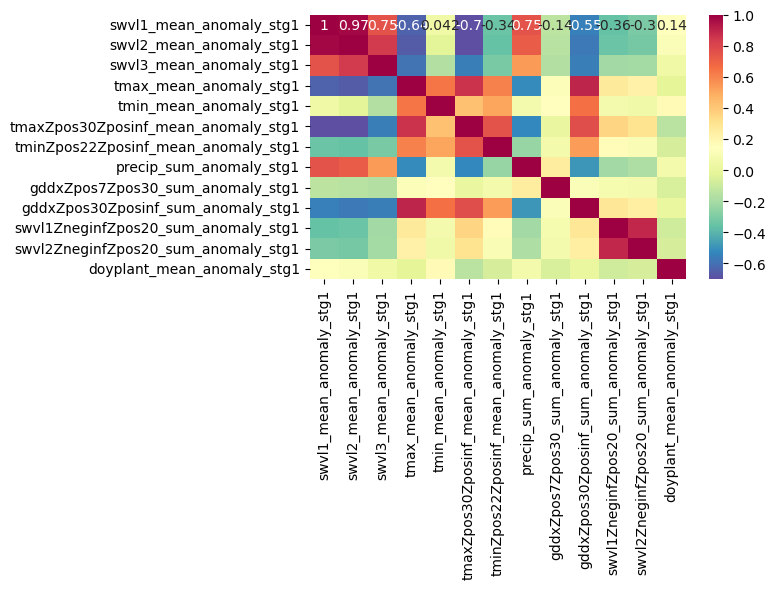

In [ ]:
vars_ano = df_pivot_stg.columns

vars_ano = vars_ano[(vars_ano.str.contains(stg_dropdown.value))&(vars_ano.str.contains(vars_dropdown.value))]

corr_matrix_ano = df_pivot_stg[vars_ano].corr()

plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["figure.autolayout"] = True
#print(corr_matrix)
sns.heatmap(round(corr_matrix_ano,3), annot=True, cmap= 'Spectral_r')
plt.show()

## Plotting the weather variables

### Importing weather shapefiles

### Merging

In [ ]:
shp_adm2_ = shp_adm2.copy()
shp_adm2_ = shp_adm2_.merge(df_pivot_stg, left_on = 'aoi_id',
                            right_on = 'aoi_id', how='left')
shp_adm2_.head(2)

,vector_id,vector_nam,state_code,aoi_name,country,state,full_name,adm0_iso,aoi_id,area,...,gddxZpos30Zposinf_sum_anomaly_stg4,swvl1ZneginfZpos20_sum_anomaly_stg1,swvl1ZneginfZpos20_sum_anomaly_stg2,swvl1ZneginfZpos20_sum_anomaly_stg3,swvl1ZneginfZpos20_sum_anomaly_stg4,swvl2ZneginfZpos20_sum_anomaly_stg1,swvl2ZneginfZpos20_sum_anomaly_stg2,swvl2ZneginfZpos20_sum_anomaly_stg3,swvl2ZneginfZpos20_sum_anomaly_stg4,doyplant_mean_anomaly_stg1
0,3509106,CAIUA,35,BR_3509106,Brazil,Sao Paulo,Caiua,BRA,54001,0.048137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3511003,CASTILHO,35,BR_3511003,Brazil,Sao Paulo,Castilho,BRA,54002,0.092484,...,-28.491992,1.665085,-0.352379,-0.488037,-0.548629,2.010705,-0.434954,-0.586798,-0.586798,22.490566


In [ ]:
shp_adm2_.shape

(30118, 65)

### Plotting

#### Trial

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

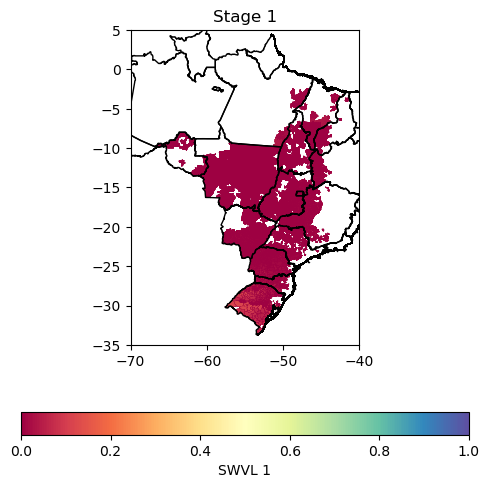

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=1, figsize=(5,5))

shp_adm2_.plot(ax=axes,column = 'swvl1_mean_anomaly_stg1',legend=True, cmap = "Spectral",
               vmin = 0, vmax = 1,
               legend_kwds = {'label': 'SWVL 1',
                              'orientation':'horizontal'})

axes.set_title('Stage 1')
#Adm1 map
shp_adm1.plot(ax=axes,facecolor = "none", edgecolor='black', linewidth = 1)
#Setting up x-limits and y-limits
axes.set_xlim(-70,-40)
axes.set_ylim(-35,5)

plt.tight_layout

#### Precipitation [Stages]

The meaning of 'enumerate' is to mention one-by-one.
 - The enumerate function takes in two parameters: iterable and start.
 - Iterable is the data collection passed in to be returned as an enumerate object.
 - Start is the starting index for enumerate object.

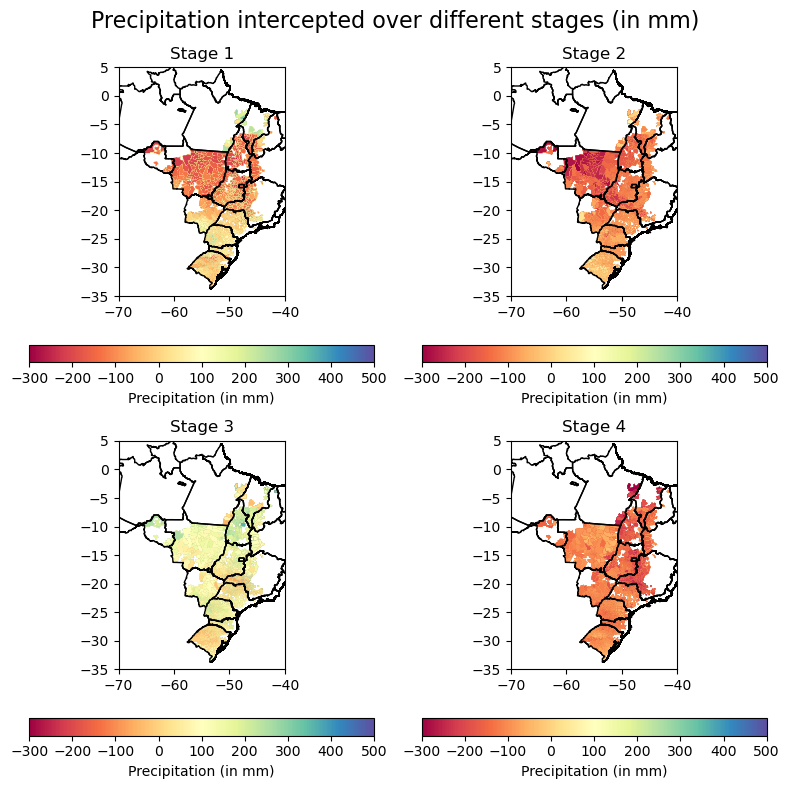

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle("Precipitation intercepted over different stages (in mm)",
             fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'precip_sum_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -300, vmax = 500,
                   legend_kwds = {'label': 'Precipitation (in mm)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout()

plt.savefig('figures/ppt_stages_anomaly.png',bbox_inches='tight')

#### GDD [Stages]

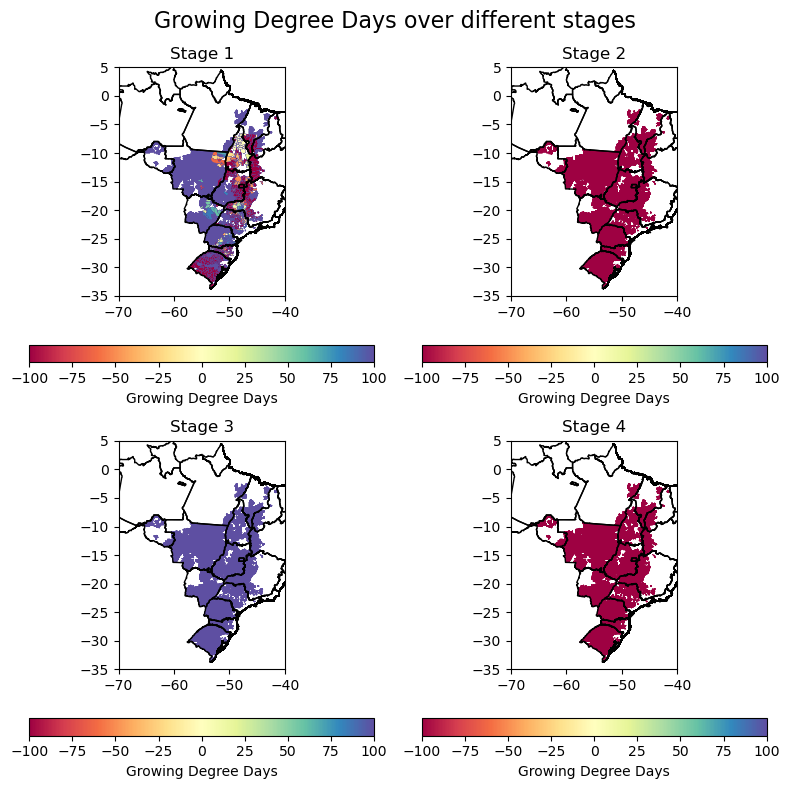

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle("Growing Degree Days over different stages",
             fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'gddxZpos7Zpos30_sum_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -100, vmax = 100,
                   legend_kwds = {'label': 'Growing Degree Days',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/gddZpos10Zpos32_anomaly.png',bbox_inches='tight')

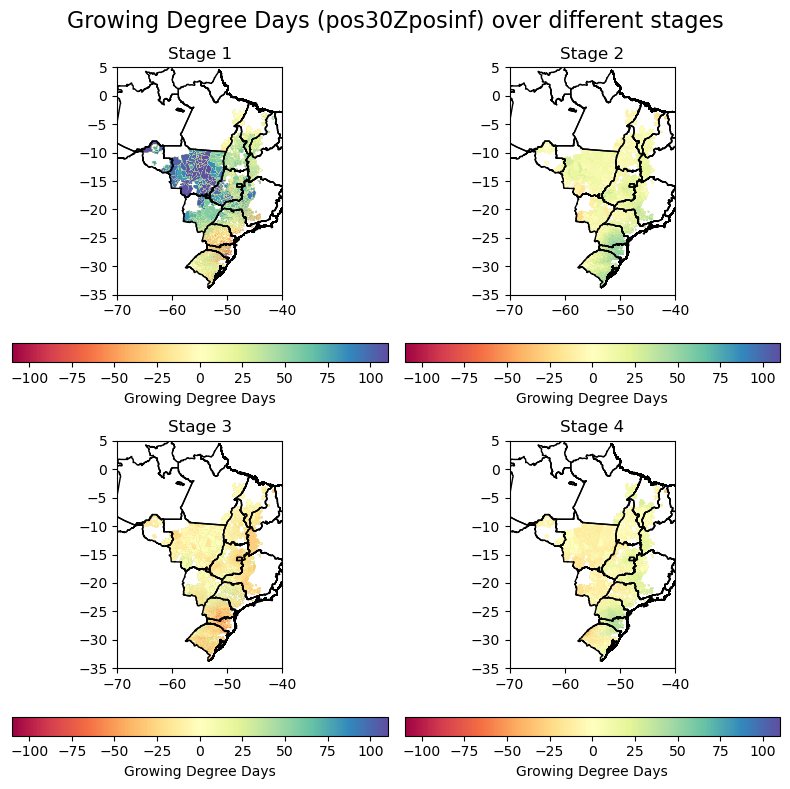

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle("Growing Degree Days (pos30Zposinf) over different stages",
             fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'gddxZpos30Zposinf_sum_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -110, vmax = 110,
                   legend_kwds = {'label': 'Growing Degree Days',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/gddZpos30Zposinf_anomaly.png',bbox_inches='tight')

#### tmin [Stages]

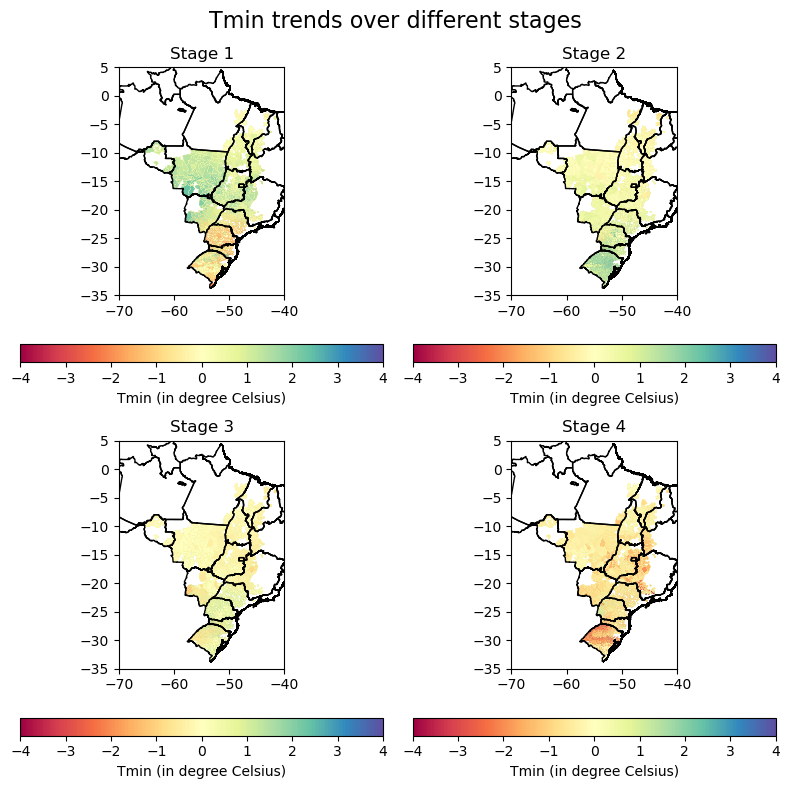

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle("Tmin trends over different stages",
             fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'tmin_mean_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -4, vmax = 4,
                   legend_kwds = {'label': 'Tmin (in degree Celsius)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/tmin_stages_anomaly.png',bbox_inches='tight')

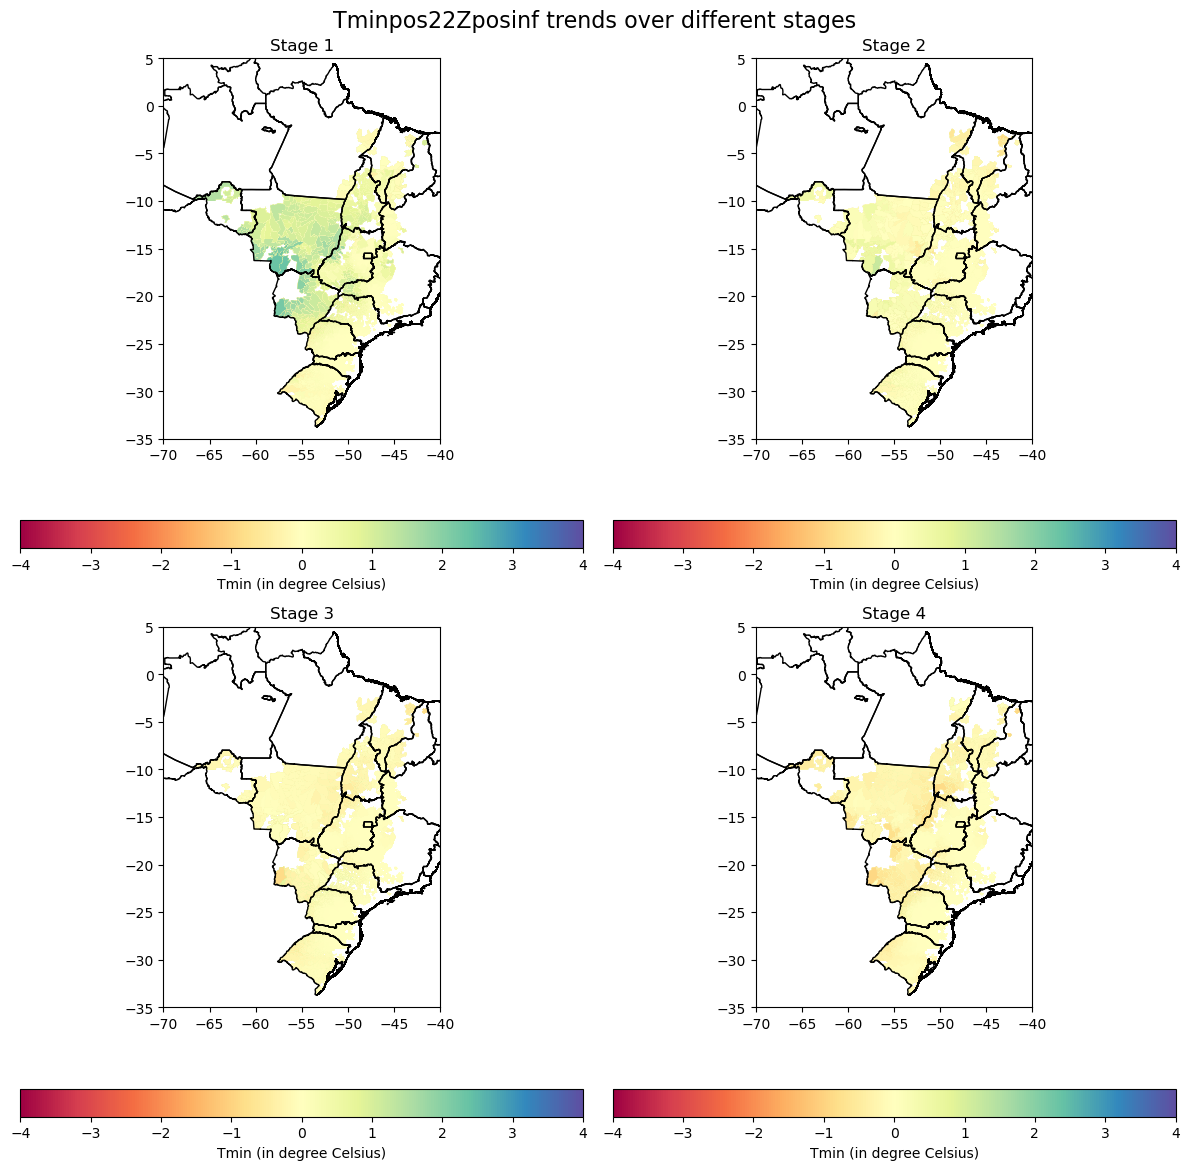

In [ ]:
plt.figure(figsize=(12,12))

plt.suptitle("Tminpos22Zposinf trends over different stages",
             fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'tminZpos22Zposinf_mean_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -4, vmax = 4,
                   legend_kwds = {'label': 'Tmin (in degree Celsius)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/tmin_pos22Zposinf_stages_anomaly.png',bbox_inches='tight')

#### tmax [Stages]

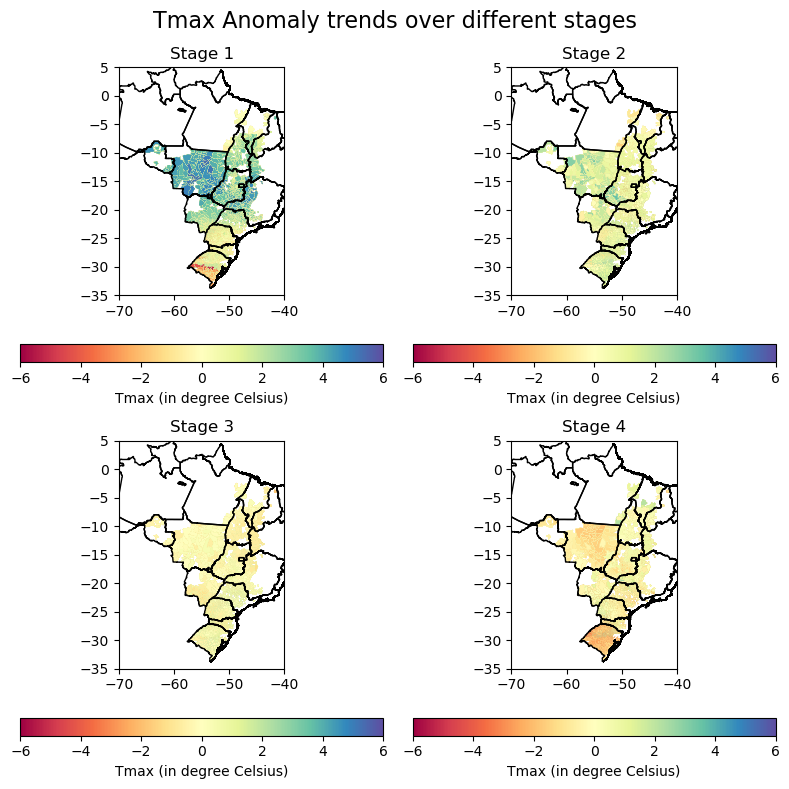

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle("Tmax Anomaly trends over different stages",
             fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'tmax_mean_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -6, vmax = 6,
                   legend_kwds = {'label': 'Tmax (in degree Celsius)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/tmax_stages_anomaly.png',bbox_inches='tight')

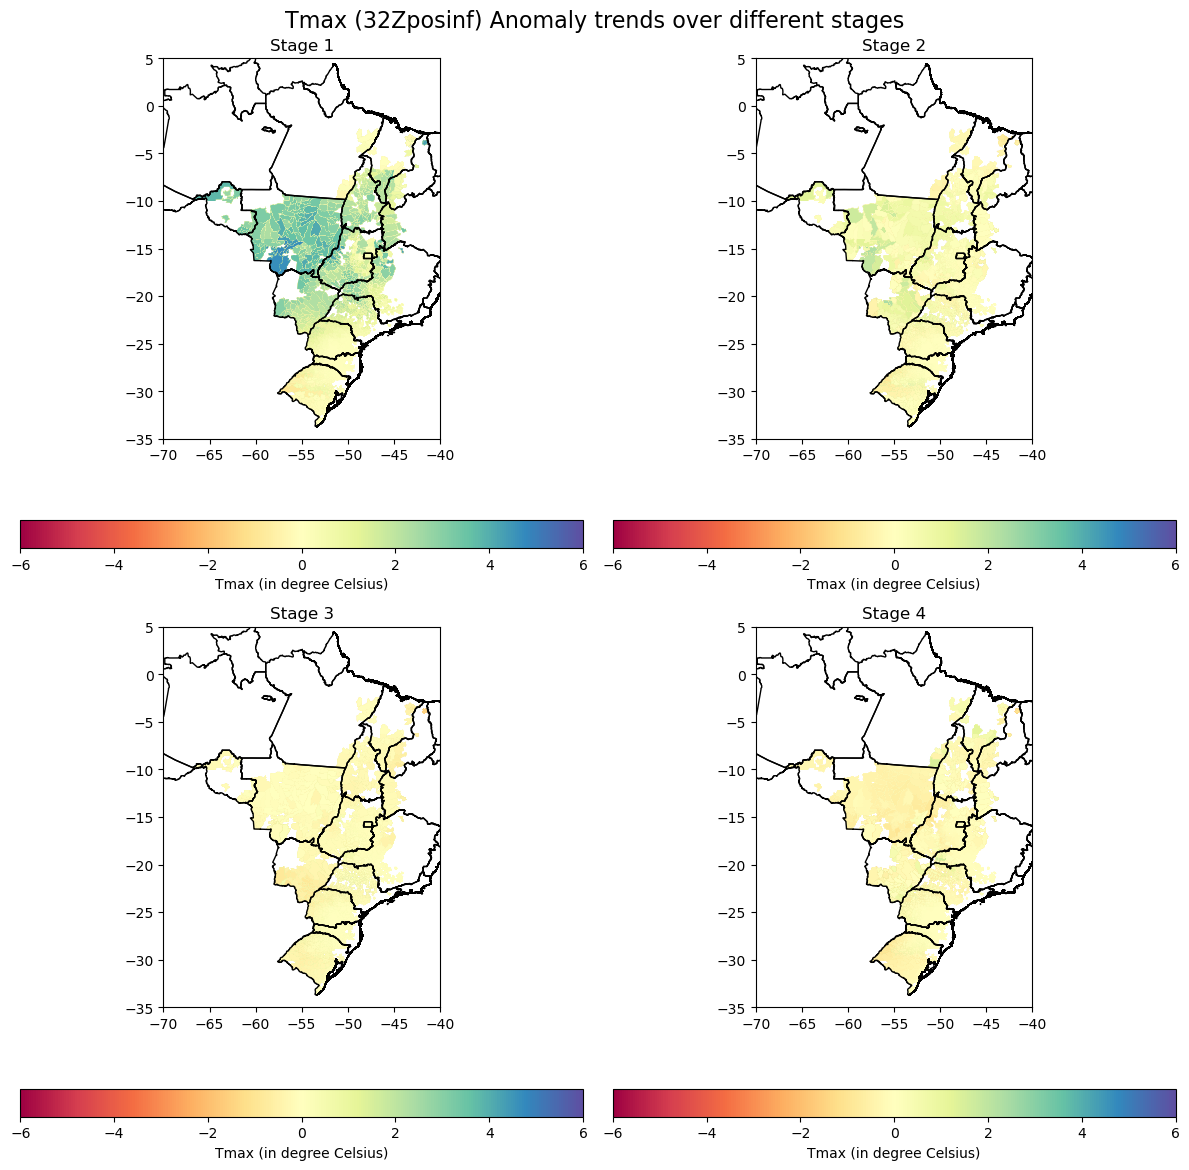

In [ ]:
plt.figure(figsize=(12,12))

plt.suptitle("Tmax (32Zposinf) Anomaly trends over different stages",
             fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'tmaxZpos30Zposinf_mean_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -6, vmax = 6,
                   legend_kwds = {'label': 'Tmax (in degree Celsius)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/tmax_stages_(32Zposinf)_anomaly.png',bbox_inches='tight')

#### Soil Moisture Level 1

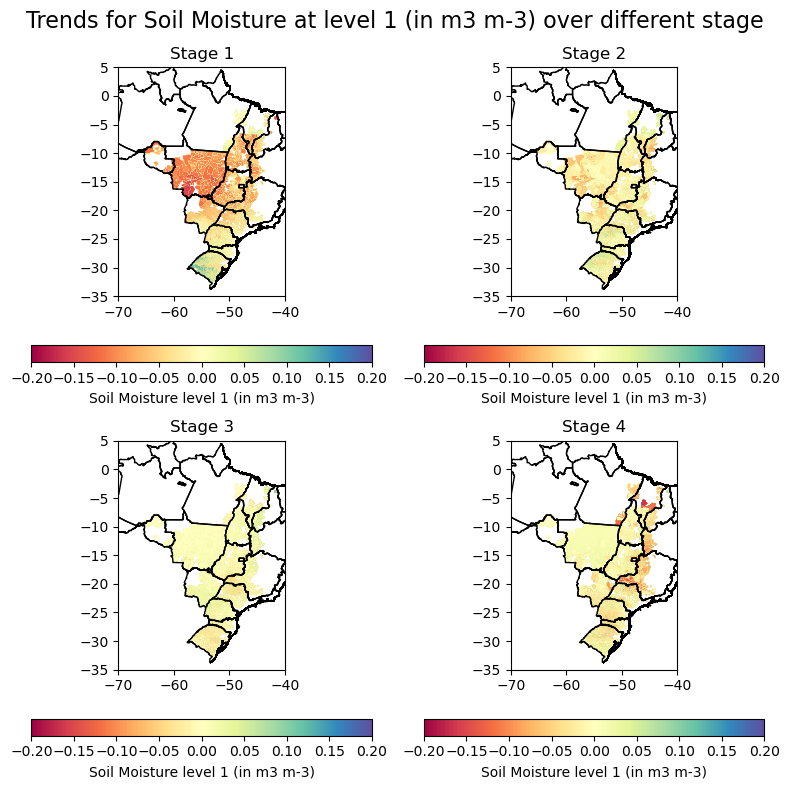

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle(
    "Trends for Soil Moisture at level 1 (in m3 m-3) over different stage",
    fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'swvl1_mean_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -0.2, vmax = 0.2,
                   legend_kwds = {'label': 'Soil Moisture level 1 (in m3 m-3)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/swvl1_stages_anomaly.png',bbox_inches='tight')

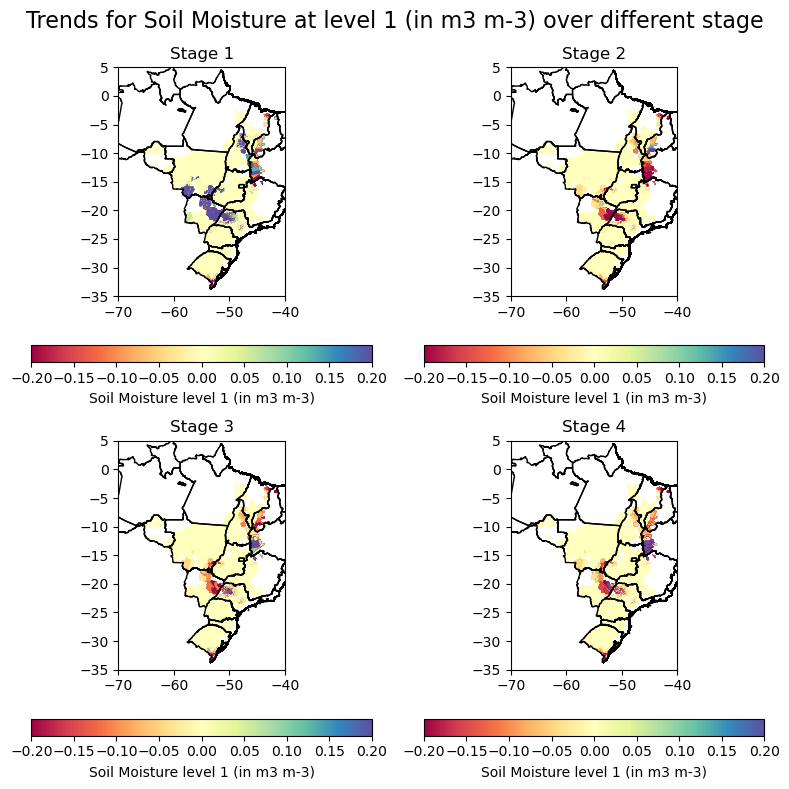

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle(
    "Trends for Soil Moisture at level 1 (in m3 m-3) over different stage",
    fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'swvl1ZneginfZpos20_sum_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -0.2, vmax = 0.2,
                   legend_kwds = {'label': 'Soil Moisture level 1 (in m3 m-3)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/swvl1_neginfZpos20_stages_anomaly.png',bbox_inches='tight')

#### Soil Moisture Level 2

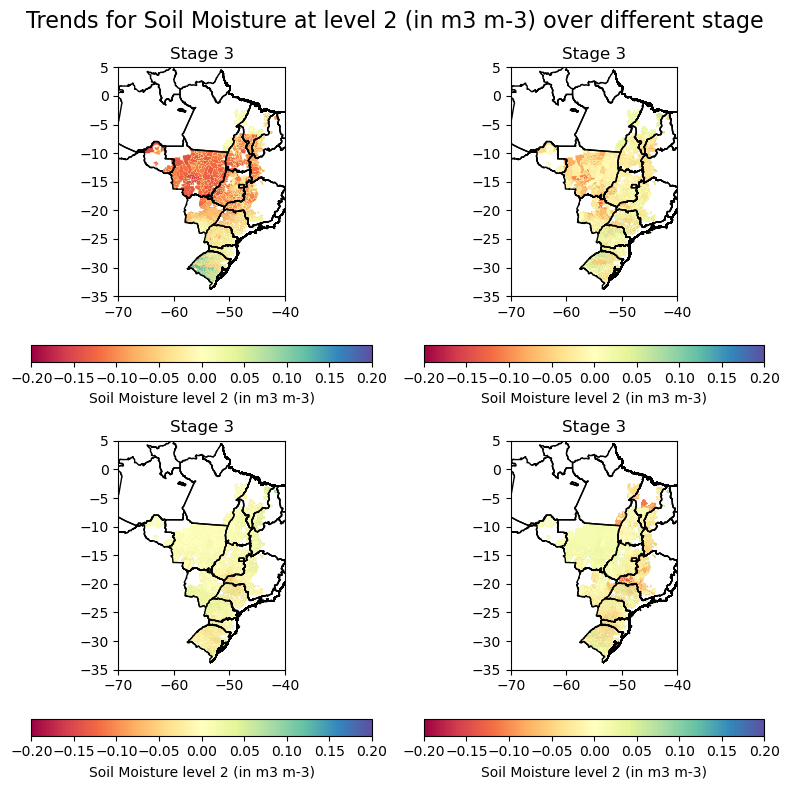

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle(
    "Trends for Soil Moisture at level 2 (in m3 m-3) over different stage",
    fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'swvl2_mean_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -0.2, vmax = 0.2,
                   legend_kwds = {'label': 'Soil Moisture level 2 (in m3 m-3)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[1]+1}')

plt.tight_layout

plt.savefig('figures/swvl2_stages_anomaly.png',bbox_inches='tight')

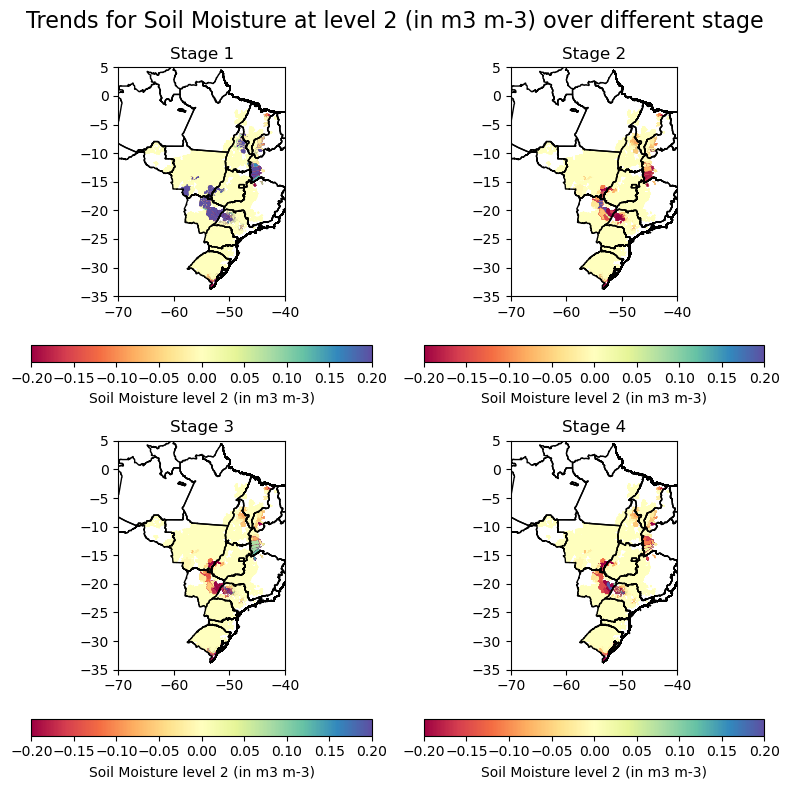

In [ ]:
plt.figure(figsize=(8,8))

plt.suptitle(
    "Trends for Soil Moisture at level 2 (in m3 m-3) over different stage",
    fontsize=16)

for n, t in enumerate(np.arange(len(stages))):

    ax = plt.subplot(2,2,n+1)

    shp_adm2_.plot(ax=ax,column = f'swvl2ZneginfZpos20_sum_anomaly_stg{stages[t]}',
                   legend=True, cmap = "Spectral",vmin = -0.2, vmax = 0.2,
                   legend_kwds = {'label': 'Soil Moisture level 2 (in m3 m-3)',
                                  'orientation':'horizontal'})

    shp_adm1.plot(ax=ax,facecolor = "none", edgecolor='black', linewidth = 1)

    ax.set_xlim(-70,-40)
    ax.set_ylim(-35,5)

    ax.set_title(f'Stage {stages[t]}')

plt.tight_layout

plt.savefig('figures/swvl2_neginfZpos20_stages_anomaly.png',bbox_inches='tight')

#### Day of Year Planting Mean

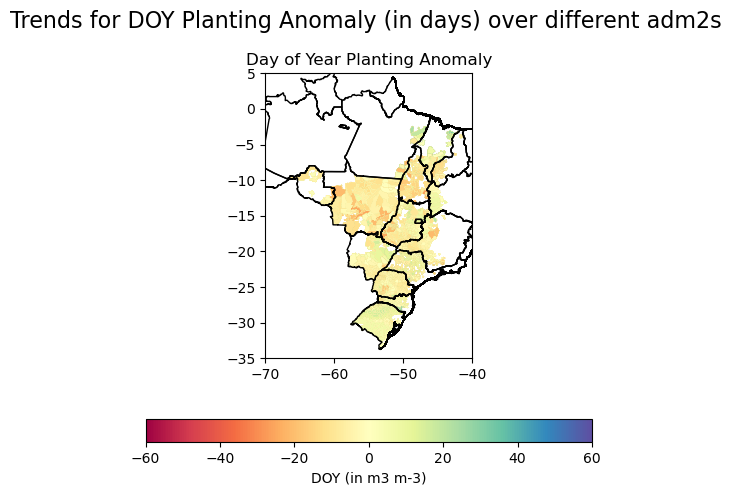

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=1, figsize=(5,5))

plt.suptitle(
    "Trends for DOY Planting Anomaly (in days) over different adm2s",
    fontsize=16)

shp_adm2_.plot(ax=axes,column = f'doyplant_mean_anomaly_stg1',
               legend=True, cmap = "Spectral",vmin = -60, vmax = 60,
               legend_kwds = {'label': 'DOY (in m3 m-3)',
                                  'orientation':'horizontal'})

shp_adm1.plot(ax=axes,facecolor = "none", edgecolor='black', linewidth = 1)

axes.set_xlim(-70,-40)
axes.set_ylim(-35,5)

axes.set_title(f'Day of Year Planting Anomaly')

plt.tight_layout

plt.savefig('figures/DOY_planting_anomaly.png',bbox_inches='tight')